# 02_feature_engineering.ipynb  
**Objetivo**: Explorar y construir nuevas características a partir del dataset limpio.  

In [14]:
from pathlib import Path
from IPython.display import display
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from src.config import INTERIM_DATA_DIR, TARGET_COLUMN, FIGURES_DIR, PROCESSED_DATA_DIR

# Preparar carpeta para figuras de feature_engineering
fig_dir = FIGURES_DIR / 'feature_engineering'
fig_dir.mkdir(parents=True, exist_ok=True)

# Cargar dataset limpio
df = pd.read_csv(INTERIM_DATA_DIR / "startup_data_clean.csv")
display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 923 entries, 0 to 922
Data columns (total 49 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Unnamed: 0                923 non-null    float64
 1   state_code                923 non-null    object 
 2   latitude                  923 non-null    float64
 3   longitude                 923 non-null    float64
 4   zip_code                  923 non-null    object 
 5   id                        923 non-null    object 
 6   city                      923 non-null    object 
 7   Unnamed: 6                923 non-null    object 
 8   name                      923 non-null    object 
 9   labels                    923 non-null    float64
 10  founded_at                923 non-null    object 
 11  closed_at                 923 non-null    object 
 12  first_funding_at          923 non-null    object 
 13  last_funding_at           923 non-null    object 
 14  age_first_

None

In [15]:
# Exploración de posibles características a crear
print("\nVerificando columnas disponibles para ingeniería de características...")
columns_by_type = {
    'Financiación': [col for col in df.columns if 'fund' in col.lower() or 'round' in col.lower()],
    'Tiempo/Edad': [col for col in df.columns if 'age' in col.lower() or 'year' in col.lower()],
    'Relaciones': [col for col in df.columns if 'relation' in col.lower()],
    'Ubicación': [col for col in df.columns if col.startswith('is_')],
    'Hitos': [col for col in df.columns if 'milestone' in col.lower()]
}
display(columns_by_type)


Verificando columnas disponibles para ingeniería de características...


{'Financiación': ['first_funding_at',
  'last_funding_at',
  'age_first_funding_year',
  'age_last_funding_year',
  'funding_rounds',
  'funding_total_usd',
  'has_roundA',
  'has_roundB',
  'has_roundC',
  'has_roundD'],
 'Tiempo/Edad': ['age_first_funding_year',
  'age_last_funding_year',
  'age_first_milestone_year',
  'age_last_milestone_year'],
 'Relaciones': ['relationships'],
 'Ubicación': ['is_CA',
  'is_NY',
  'is_MA',
  'is_TX',
  'is_otherstate',
  'is_software',
  'is_web',
  'is_mobile',
  'is_enterprise',
  'is_advertising',
  'is_gamesvideo',
  'is_ecommerce',
  'is_biotech',
  'is_consulting',
  'is_othercategory',
  'is_top500'],
 'Hitos': ['age_first_milestone_year',
  'age_last_milestone_year',
  'milestones']}

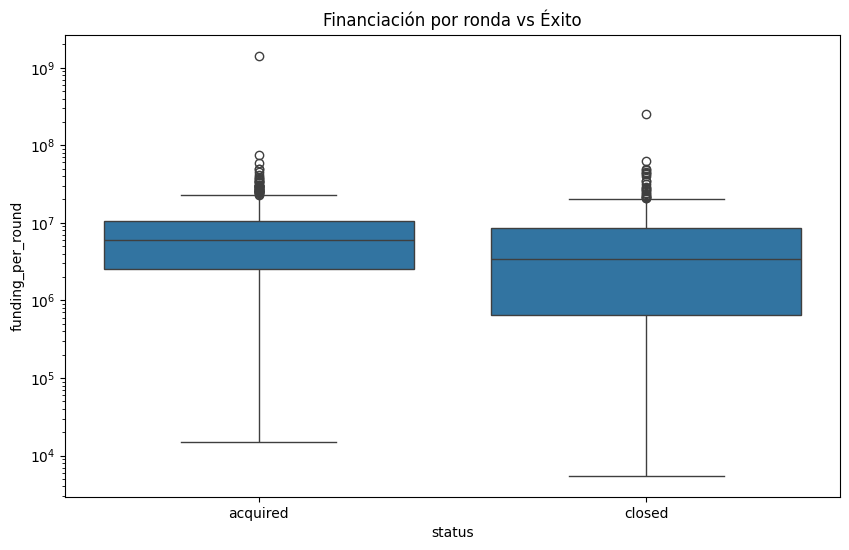

,count,mean,std,min,25%,50%,75%,max
status,,,,,,,,
acquired,597.0,1.069247e+07,5.863062e+07,14925.0,2.533333e+06,6.000000e+06,1.062500e+07,1.425000e+09
closed,326.0,7.258446e+06,1.650597e+07,5500.0,6.512500e+05,3.425714e+06,8.650008e+06,2.550000e+08


In [16]:
from src.features.feature_engineering import add_funding_per_round
from IPython.display import display

# 1) Crea la feature
if 'funding_total_usd' in df.columns and 'funding_rounds' in df.columns:
    df = add_funding_per_round(df)

    # 2) Visualiza con escalado log
    fig, ax = plt.subplots(figsize=(10,6))
    sns.boxplot(x=TARGET_COLUMN, y='funding_per_round', data=df, ax=ax)
    ax.set_yscale('log')
    ax.set_title('Financiación por ronda vs Éxito')
    fig.savefig(fig_dir/'funding_per_round.png', bbox_inches='tight')
    plt.show()

    # 3) Estadísticas descriptivas
    display(df.groupby(TARGET_COLUMN)['funding_per_round'].describe())

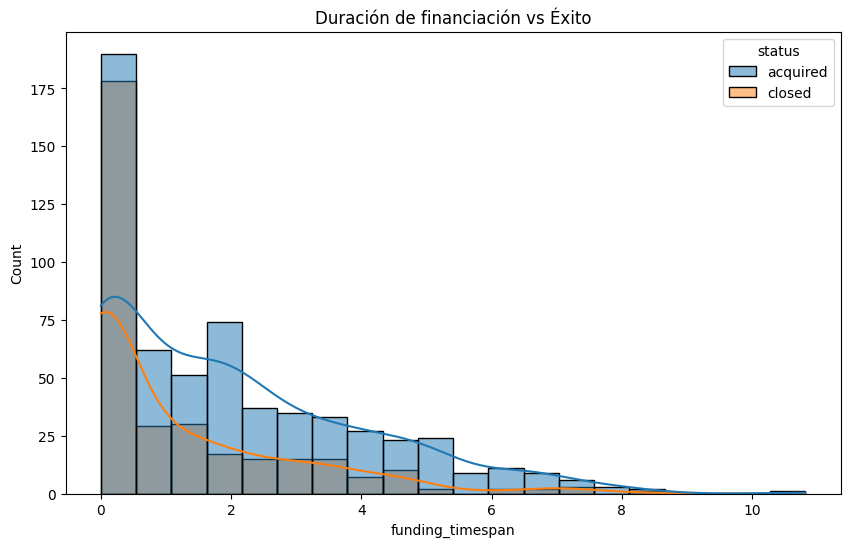

,count,mean,std,min,25%,50%,75%,max
status,,,,,,,,
acquired,597.0,1.997683,2.010627,0.0,0.0,1.5726,3.12880,10.8192
closed,326.0,1.143037,1.658751,0.0,0.0,0.0151,1.87055,8.1671


In [17]:
from src.features.feature_engineering import add_funding_timespan
from IPython.display import display

# 1) Crea la feature de forma limpia
if 'age_first_funding_year' in df.columns and 'age_last_funding_year' in df.columns:
    df = add_funding_timespan(df)

    # 2) Gráfico de histograma con KDE y hue
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.histplot(data=df,
                 x='funding_timespan',
                 hue=TARGET_COLUMN,
                 bins=20,
                 kde=True,
                 ax=ax)
    ax.set_title('Duración de financiación vs Éxito')
    fig.savefig(fig_dir / 'funding_timespan.png', bbox_inches='tight')
    plt.show()

    # 3) Estadísticas descriptivas por clase
    display(df.groupby(TARGET_COLUMN)['funding_timespan'].describe())

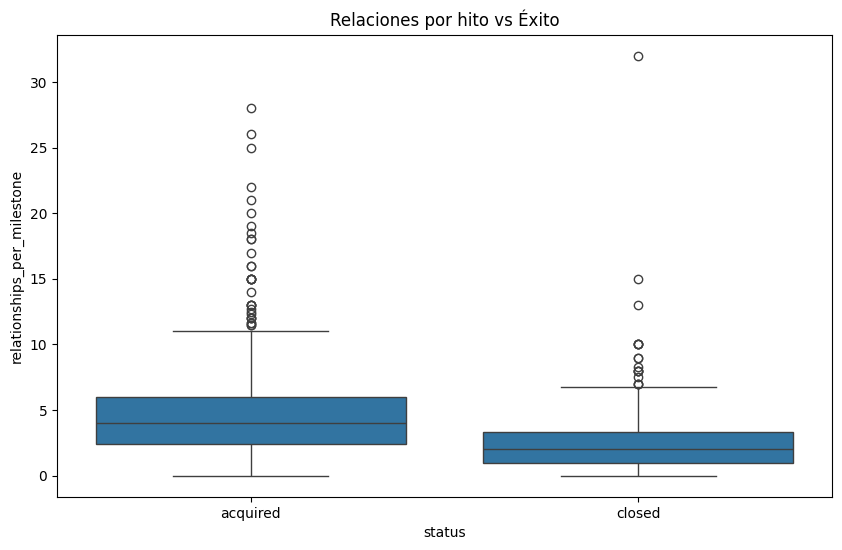

,count,mean,std,min,25%,50%,75%,max
status,,,,,,,,
acquired,597.0,4.772125,3.694490,0.0,2.4,4.0,6.000000,28.0
closed,326.0,2.694632,2.716461,0.0,1.0,2.0,3.333333,32.0


In [18]:
from src.features.feature_engineering import add_relationships_per_milestone
from IPython.display import display

# 1) Generar la nueva feature
if 'relationships' in df.columns and 'milestones' in df.columns:
    df = add_relationships_per_milestone(df)

    # 2) Visualizar con boxplot
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.boxplot(
        x=TARGET_COLUMN,
        y='relationships_per_milestone',
        data=df,
        ax=ax
    )
    ax.set_title('Relaciones por hito vs Éxito')
    fig.savefig(fig_dir / 'relationships_per_milestone.png', bbox_inches='tight')
    plt.show()

    # 3) Estadísticas descriptivas
    display(df.groupby(TARGET_COLUMN)['relationships_per_milestone'].describe())

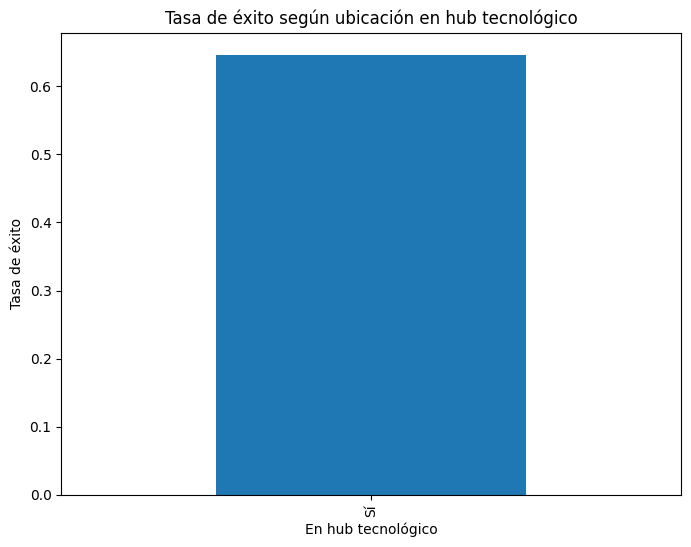

in_tech_hub
Sí    0.646804
Name: status_numeric, dtype: float64

In [21]:
# 1) Calcula la tasa y renombra índice
success_by_hub = (
    df.groupby('in_tech_hub')['status_numeric']
      .mean()
      .rename(index={0: 'No', 1: 'Sí'})
)

# 2) Dibuja el bar chart usando el índice renombrado
fig, ax = plt.subplots(figsize=(8, 6))
success_by_hub.plot(kind='bar', ax=ax)
ax.set_title('Tasa de éxito según ubicación en hub tecnológico')
ax.set_xlabel('En hub tecnológico')
ax.set_ylabel('Tasa de éxito')
fig.savefig(fig_dir / 'tech_hub_success.png', bbox_inches='tight')
plt.show()

# 3) Muestra la tabla
from IPython.display import display
display(success_by_hub)

c:\Users\alexl\OneDrive\Escritorio\Machine Learning\startups-ml\venv\Lib\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\alexl\OneDrive\Escritorio\Machine Learning\startups-ml\venv\Lib\site-packages\numpy\lib\_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


,corr_con_target
funding_per_round,0.034089
funding_timespan,0.211053
relationships_per_milestone,0.282007
in_tech_hub,NaN


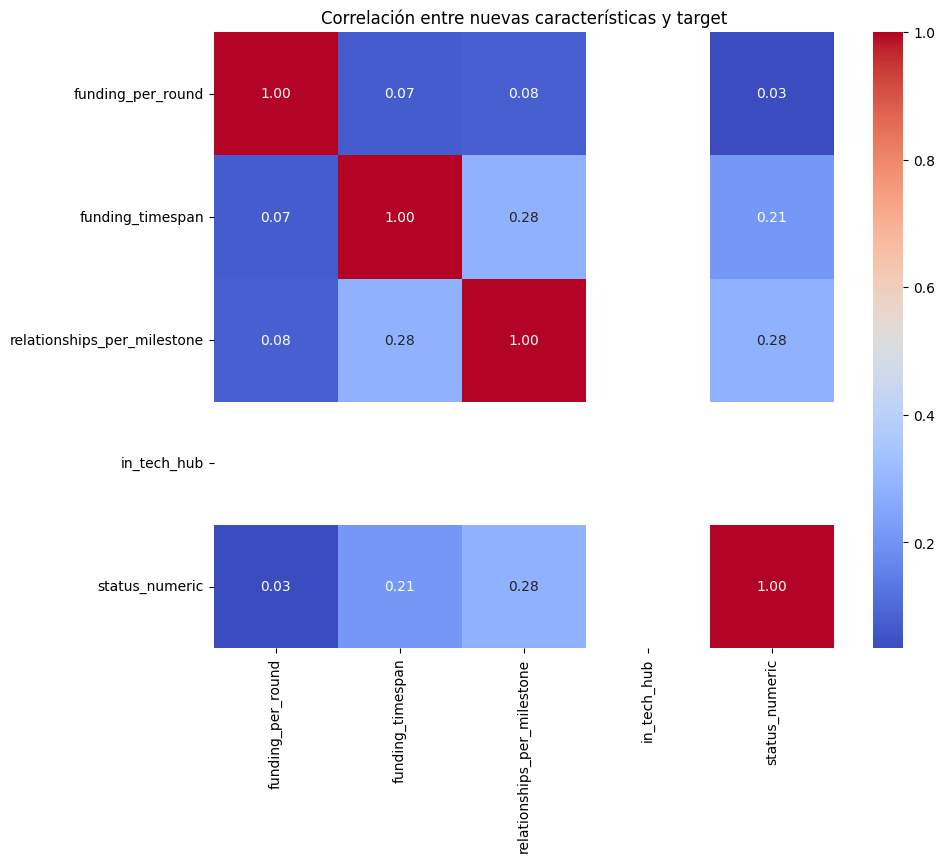

In [22]:
# ————————————————————————————————
# Correlación de nuevas características vs target
# ————————————————————————————————

# 1) Asegurar columna numérica del target
if 'status_numeric' not in df.columns:
    df['status_numeric'] = df[TARGET_COLUMN].map({'acquired': 1, 'closed': 0})

# 2) Definir y filtrar features disponibles
new_features = [
    'funding_per_round',
    'funding_timespan',
    'relationships_per_milestone',
    'in_tech_hub'
]
available = [f for f in new_features if f in df.columns]

if available:
    # 3) Serie de correlaciones
    import pandas as pd
    corr_ser = df[available].apply(lambda col: col.corr(df['status_numeric']))
    corr_ser.name = 'corr_con_target'
    display(corr_ser.to_frame())

    # 4) Heatmap de la matriz de correlación
    corr_df = df[available + ['status_numeric']].corr()
    fig, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(
        corr_df,
        annot=True,
        cmap='coolwarm',
        fmt='.2f',
        ax=ax
    )
    ax.set_title('Correlación entre nuevas características y target')
    fig.savefig(fig_dir / 'new_features_correlation.png', bbox_inches='tight')
    plt.show()

In [23]:
from IPython.display import display

# Guardar el DataFrame con las nuevas features
df_with_features = df.copy()
df_with_features.to_csv(INTERIM_DATA_DIR / "startup_data_with_new_features.csv", index=False)

# Resumen visual y numérico
n_total = len(df.columns)
n_nuevas = len([f for f in new_features if f in df.columns])
n_originales = n_total - n_nuevas

print("\nResumen de ingeniería de características:")
print(f"- Características originales: {n_originales}")
print(f"- Nuevas características creadas: {n_nuevas}")
print(f"- Total características: {n_total}")

# Mostrar las primeras filas para inspección rápida
display(df_with_features.head())


Resumen de ingeniería de características:
- Características originales: 50
- Nuevas características creadas: 4
- Total características: 54


,Unnamed: 0,state_code,latitude,longitude,zip_code,id,city,Unnamed: 6,name,labels,...,has_roundC,has_roundD,avg_participants,is_top500,status,funding_per_round,funding_timespan,relationships_per_milestone,in_tech_hub,status_numeric
0,1005.0,CA,42.358880,-71.056820,92101,c:6669,San Diego,San Francisco CA 94105,Bandsintown,1.0,...,0.0,0.0,1.0000,0.0,acquired,1.250000e+05,0.7534,1.0,1.0,1
1,204.0,CA,37.238916,-121.973718,95032,c:16283,Los Gatos,San Francisco CA 94105,TriCipher,1.0,...,1.0,1.0,4.7500,1.0,acquired,1.002500e+07,4.8713,9.0,1.0,1
2,1001.0,CA,32.901049,-117.192656,92121,c:65620,San Diego,San Diego CA 92121,Plixi,1.0,...,0.0,0.0,4.0000,1.0,acquired,2.600000e+06,0.0000,2.5,1.0,1
3,738.0,CA,37.320309,-122.050040,95014,c:42668,Cupertino,Cupertino CA 95014,Solidcore Systems,1.0,...,1.0,1.0,3.3333,1.0,acquired,1.333333e+07,2.1836,5.0,1.0,1
4,1002.0,CA,37.779281,-122.419236,94105,c:65806,San Francisco,San Francisco CA 94105,Inhale Digital,0.0,...,0.0,0.0,1.0000,1.0,closed,6.500000e+05,1.6685,2.0,1.0,0


In [ ]:
from src.features.feature_engineering import create_features

# Asumiendo que “df” ya está cargado y limpio
df_feat = create_features(df)
display(df_feat.head())